In [28]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import random
import cmath
#import pylops # might not need
import math
import pyproximal

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable, deserialize_keras_object
from tensorflow.test import compute_gradient

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize

import autosetup

In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Some nice tensorflow links
https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#putting_it_all_together_an_end-to-end_example 
https://www.tensorflow.org/guide/keras/functional_api
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#used-in-the-notebooks
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#call

## Autoencoder

### Dataset

In [3]:
# code from: https://www.tensorflow.org/tutorials/generative/autoencoder

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255. #normalize the data
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# make a smaller training set
x_train_temp = x_train[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [10,10])
x_train_small = x_train_temp[:,:,:,0]

x_test_temp = x_test[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [10,10])
x_test_small = x_test_temp[:,:,:,0]

#x_train_small = tf.image.resize(x_train, [10, 10])
#x_test_small = tf.image.resize(x_test, [10, 10])

print(x_train_small.shape)
print(x_test_small.shape)

# make a complex (smaller) training set
x_train_cx_small = tf.complex(np.ones((x_train_small.shape)).astype('float32'), x_train_small)
x_test_cx_small = tf.complex(np.ones((x_test_small.shape)).astype('float32'), x_test_small)

print(x_train_cx_small.shape)
print(type(x_train_cx_small))

(60000, 28, 28)
(10000, 28, 28)
(60000, 10, 10)
(10000, 10, 10)
(60000, 10, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>


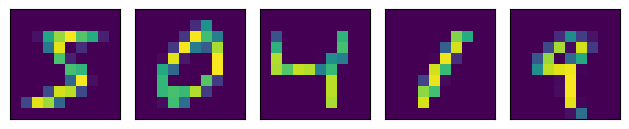

In [4]:
# representation training dataset (real case)
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = x_train_small[i]
    ax[i].imshow(np.real(x).reshape((10,10)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

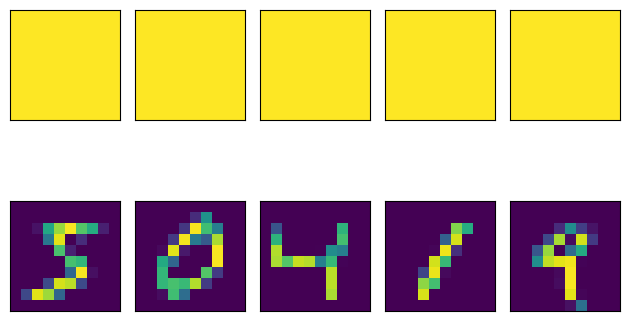

In [5]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = x_train_cx_small[i]
    ax[0,i].imshow(np.real(x).reshape((10,10)),clim=[0,1], cmap= 'viridis')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((10,10)),clim=[0,1], cmap='viridis')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()


### Layer and model classes
todo transport to separate files

In [33]:
test_layer = autosetup.ComplexEncoder(10)
test_layer2 = autosetup.ComplexDencoder(100)

# create x_example
x_testing = tf.reshape(x_train_cx_small[0], [1,-1])
print(x_testing.shape)
print(type(x_testing))

# output of the autoencoder model encoder (untrained)
y = test_layer(x_testing)
#print(y)
print(len(test_layer.weights)) # i think it's 3 because i have 3 objects..?

# testing autoencoder decoder (untrained)
z_testing = tf.complex(2.0*np.ones(10, dtype=np.float32), 1.2*np.ones(10, dtype=np.float32))
x_recon = test_layer2(y)

#print(x_recon)

# test activation fuction
seq = np.array([-10,-5,0,5,10])
c_seq = np.array([-2,-1,0,1,2])
real_tensor = tf.convert_to_tensor(seq.astype('float32'))
imag_tensor = tf.convert_to_tensor(c_seq.astype('float32'))
c_tensor = tf.complex(real_tensor, imag_tensor)

print(c_tensor)
modrelu = lambda z: autosetup.modrelu(z, b=-1, c=0)
#print(modrelu(real_tensor))
print(modrelu(c_tensor))
print(np.abs(c_tensor))
print(np.abs(modrelu(c_tensor)))

# test loss function 
aL = 2*c_tensor 
loss = autosetup.loss_MSE(aL, c_tensor)
print(loss)

print(autosetup.dLossdaL(aL, c_tensor))


(1, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>
3
tf.Tensor([-10.-2.j  -5.-1.j   0.+0.j   5.+1.j  10.+2.j], shape=(5,), dtype=complex64)
tf.Tensor(
[-9.01942 -1.8038839j  -4.019419-0.80388385j       nan       +nanj
  4.019419+0.80388385j  9.01942 +1.8038839j ], shape=(5,), dtype=complex64)
[10.198039   5.0990195  0.         5.0990195 10.198039 ]
[9.198039  4.0990195       nan 4.0990195 9.198039 ]
tf.Tensor(260.0, shape=(), dtype=float32)
(<tf.Tensor: shape=(5,), dtype=complex64, numpy=array([-10.+2.j,  -5.+1.j,   0.-0.j,   5.-1.j,  10.-2.j], dtype=complex64)>, <tf.Tensor: shape=(5,), dtype=complex64, numpy=array([-10.-2.j,  -5.-1.j,   0.+0.j,   5.+1.j,  10.+2.j], dtype=complex64)>)


In [62]:
def arctan_complex(z, dtype=tf.complex64):
    return tf.convert_to_tensor(cmath.atan(z), dtype=tf.complex64)

x = tf.complex(1.0,2.0)
x = tf.reshape(x, [1,-1])
print(x)
print(type(x))
y = arctan_complex(x)
print(y)
print(type(y))



tf.Tensor([[1.+2.j]], shape=(1, 1), dtype=complex64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor((1.3389726+0.4023595j), shape=(), dtype=complex64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [6]:
@register_keras_serializable()
class Autoencoder(Model):
  def __init__(self, latent_dim, shape, **kwargs):
    super().__init__(**kwargs)
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])
  

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  

  def get_config(self):
    config = super().get_config()
    config.update(
      {
        "latent_dim": self.latent_dim,
        "shape": self.shape,
       # "encoder": self.encoder,
       # "decoder": self.decoder,
      }
    )
    return config

  # can be removed I think
  # @classmethod
  # def from_config(cls, config):
  #     config["latent_dim"] = deserialize_keras_object(config["latent_dim"])
  #     config["shape"] = deserialize_keras_object(config["shape"])
  #     #config["encoder"] = deserialize_keras_object(config["encoder"])
  #     #config["decoder"] = deserialize_keras_object(config["decoder"])
  #     return cls(**config)


shape = x_test_small.shape[1:]
latent_dim = 10
autoencoder = Autoencoder(latent_dim, shape)
print(len(autoencoder.layers))
print(shape)

2
(10, 10)


In [40]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError()) # configuration of the model for training, adam is a stochastic gradient method that estimates moments
autoencoder.fit(x_train_cx_small, x_train_cx_small,
                epochs=10, # number of times the entire training dataset is run through the model
                shuffle=True, # shuffles the data set before each training epoch
                validation_data=(x_test_cx_small, x_test_cx_small)) # validation at the end of each epoch
                # batch size is 32 by default

autoencoder.summary()

Epoch 1/10


1658/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4029

KeyboardInterrupt: 

##### Load & save autoencoder model

In [8]:
autoencoder.save('autoencoder_10epochs_mnist_10x10.keras')

In [9]:
autoencoder_reconstructed = tf.keras.models.load_model('autoencoder_10epochs_mnist_10x10.keras')
autoencoder_reconstructed.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 10)               │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 10, 10)           │         1,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,332 (24.74 KB)

 Trainable params: 2,110 (8.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,222 (16.50 KB)

(10000, 10)
(10000, 10, 10)


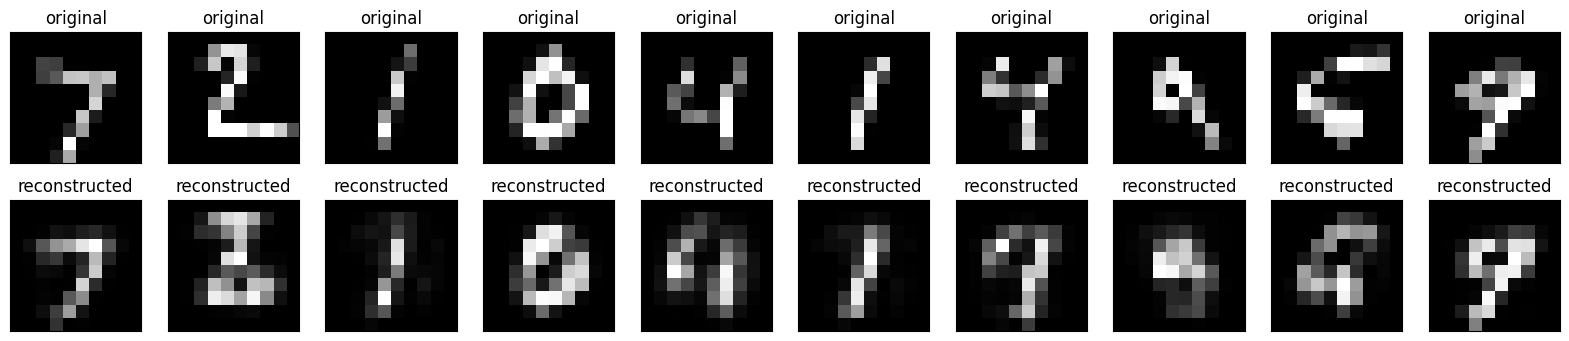

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 10)               │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 10, 10)           │         1,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,332 (24.74 KB)

 Trainable params: 2,110 (8.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,222 (16.50 KB)

In [10]:
encoded_imgs = autoencoder.encoder(x_test_small).numpy()
print(encoded_imgs.shape)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(decoded_imgs.shape)

ns = 10
plt.figure(figsize=(20, 4))
for i in range(ns):
  # display original
  ax = plt.subplot(2, ns, i + 1)
  plt.imshow(x_test_small[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, ns, i + 1 + ns)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

autoencoder.summary()


#### Extracting autoencoder function

(1, 10, 10)


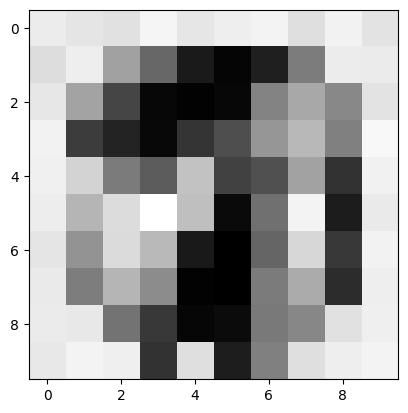

In [11]:
# random input looks like this
z_random = np.random.normal(size=(1,10))
test_z = autoencoder.decoder(z_random) #test_z is a tf 
print(test_z.shape)

plt.figure()
plt.imshow(test_z[0])

In [ ]:
# OLD SAVE FOR NOW IF IT GETS WORSE
# # compute gradient function
# def grad_decoder_1D(decoder, input_dim):
#     '''
#     first wrap decoder into tensorflow function to improve computation speed
#     specifically also changes 2D output to 1D output

#     input:
#         decoder:        the autoencoder.decoder as input, maps 1D input z to 2D output
#         input_dim:      int, size of the input dimension (usually representing latent space)

#     output:
#         jac_operator:   a function that computes the jacobian wrt input z and returns the gradients and output in terms of a tensor

#     '''
#     decoder_1D = lambda x : tf.reshape(decoder(x), [tf.shape(decoder(x))[0], -1])

#     @tf.function(reduce_retracing=True)
#     def jac_operator(z):
#         '''
#         input:
#             z:      vector in the latent space, size = (sample size, dimension latent space)
#         '''
#         z = tf.convert_to_tensor(z) # leaves z unchanged if input is already in form of tf.tensor
#         z = tf.reshape(z, [-1, input_dim]) # leaves z unchanged if size is already shaped (sample size, dim latent space), else performs 2D array conversion

#         with tf.GradientTape() as tape:
#             tape.watch(z)           # record derivatives
#             output = decoder_1D(z)     # the function to compute the derivative of

#         # gradient wrt z = (batch size, input length)
#         gradients = tape.batch_jacobian(output, z)

#         return output, gradients
    
#     return jac_operator

# def make_tensor_shape(z):
#     #z = z.reshape((1,-1))
#     tensor_z = tf.convert_to_tensor(z, dtype=tf.float32)
#     return tf.reshape(tensor_z,[1,-1])


# decoderfun_2D  = lambda z : autoencoder.decoder(z) 

# test_jac = grad_decoder_1D(decoderfun_2D, latent_dim)
# output, grads = test_jac(z_random)

# print(output.shape)
# print(grads.shape)

(1, 100)
(1, 100, 10)
tf.Tensor([[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]], shape=(1, 10), dtype=float32)


In [12]:
# compute function generative map
def make_tensor_shape(z):
    #z = z.reshape((1,-1))
    tensor_z = tf.convert_to_tensor(z, dtype=tf.float32)
    return tf.reshape(tensor_z,[1,-1])

def make_tensor(z):
    return tf.convert_to_tensor(z, dtype=tf.float32)

def decoderfunc_1D(decoder, z):
    '''
    Converts the autoencoder.decoder function into a generative embedding function.

    input:
        decoder:        keras sequential (intended use: autoencoder.decoder), numpy.array(sample size, latent_dim) --> tensor(sample size, dim x dim))    
        z:              np.array of length (latent_dim)

    output:
        decoderfunc_1D: function that maps z to numpy array of lenght dim^2 (flattened original image)
    '''
    return decoder(tf.reshape(make_tensor(z), [1,-1])).numpy().flatten() 

# compute Jacobian generative map
def jac_decoder_1D(decoder, input_dim):
    '''
    currently creates function that only handles 1D input

    first wrap decoder into tensorflow function to improve computation speed
    specifically also changes 2D output to 1D output
    can only handle z as 1D input

    input:
        decoder:        keras sequential, numpy.array(sample size, latent_dim) --> tensor(sample size, dim x dim)) 
        input_dim:      int, size of the input dimension (usually representing latent space)

    output:
        jac_operator:   a function that computes the jacobian wrt input z and returns the gradients and output in terms of a tensor

    '''
    decoder_1D = lambda x : tf.reshape(decoder(x), [tf.shape(decoder(x))[0], -1])

    @tf.function(reduce_retracing=True)
    def jac_operator_tf(z):
        '''
        input:
            z:      vector in the latent space, np.array of length input_dim
        '''
        z = tf.convert_to_tensor(z) # leaves z unchanged if input is already in form of tf.tensor
        z = tf.reshape(z, [1, input_dim]) # leaves z unchanged if size is already shaped (sample size, dim latent space), else performs 2D array conversion

        with tf.GradientTape() as tape:
            tape.watch(z)           # record derivatives
            output = decoder_1D(z)     # the function to compute the derivative of

        # gradient wrt z = (batch size, input length)
        gradients = tape.batch_jacobian(output, z)

        return gradients
    
    def jac_operator(z):
        gradients = jac_operator_tf(z)
        return gradients[0].numpy()

    return jac_operator


encode = autoencoder.encoder(x_test_small)
print(encode.shape)

x1 = encode[0,:] # test object
y1 = decoderfunc_1D(autoencoder.decoder, x1)
print(y1.shape)
y1_recon = y1.reshape((10,10))

compute_jac = jac_decoder_1D(autoencoder.decoder, latent_dim)
dGdx = compute_jac(x1)

print(type(dGdx))
print(dGdx.shape)


(10000, 10)
(100,)
<class 'numpy.ndarray'>
(100, 10)


### Set-up from ptygenography

In [28]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)

    #print("Dx", Dx.shape)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    #print("Dy", Dy.shape)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    print("xtrue", xtrue.shape)
    print("yobs", yobs.shape)
    print("k", k)
    print("m", m)

    # inference
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [14]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [15]:
# parameters
mx      = 10       # number of masks
nx      = shape[0]  # one side of the image
n       = nx**2     # total length of one image

In [16]:
# define forward operator with binary masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(1000, 100)


In [26]:
# get prior from decoder
k               = latent_dim
compute_jac     = jac_decoder_1D(autoencoder.decoder, latent_dim)
block_identity  = lambda mat : np.concatenate((mat, np.eye(n)), axis=1)


#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

G = Op(fun = lambda z : decoderfunc_1D(autoencoder.decoder, z), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : compute_jac(z) @ v, rmatvec = lambda v : np.conj(compute_jac(z).T) @ v),
       shape = (n,k))

H = Op(fun = lambda z : decoderfunc_1D(autoencoder.decoder, z[:k]) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_identity(compute_jac(z[:k])) @ v, rmatvec = lambda v : np.conj(block_identity(compute_jac(z[:k])).T) @ v),
       shape = (n,k+n))

# G = Op(fun = lambda z : decoderfunc_1D(autoencoder.decoder, z), 
#        jac = lambda z: (
#                 lambda grads: LinearOperator(
#                     (n, k),
#                     matvec=lambda v: grads @ v,
#                     rmatvec=lambda v: np.conj(grads.T) @ v
#                 )
#             )(decoderfun_1D(make_tensor_shape(z))[1].numpy()), 
#         shape = (n,k))

# H = Op(fun = lambda z : (decoderfun_1D(make_tensor_shape(z[:,:k]))[0].numpy() + z[:,k:]).flatten(), 
#        jac = lambda z: (
#                 lambda grads: LinearOperator(
#                     (n, k+n),
#                     matvec=lambda v: grads @ v,
#                     rmatvec=lambda v: np.conj(grads.T) @ v
#                 )
#             )(np.concatenate((decoderfun_1D(make_tensor_shape(z[:,:k]))[1].numpy()[0], np.eye(n)), axis=1)),  
#         shape=(n, k+n))


#G = Op(fun = lambda z : decoderfun_1D(make_tensor(z))[0].numpy(),  
       #jac = lambda z : LinearOperator((n, k), matvec = lambda x : decoderfun_1D(make_tensor(z))[1].numpy()@x, rmatvec = lambda y : np.conj(decoderfun_1D(make_tensor(z))[1].numpy().T)@y), shape=(n,k))
#H = Op(fun = lambda z : mu + C@z, jac = lambda z : LinearOperator((n, k+n), matvec = lambda z : C@z, rmatvec = lambda z : np.conj(C.T)@z), shape=(n,k+n))

# define weights
w = 1

# test
z_testing = np.ones(10)
x_testing = np.ones(100)
y_testing = np.ones((1000))
h_testing = np.ones((110))

G_jac = G.jac(z_testing)
G_H = G_jac.H

print(G_jac.shape)
print(G_H.shape)

print(type(G_jac))
print(type(G_H))

G_jac@z_testing
print((G_jac@z_testing).shape)

H_test = block_identity(compute_jac(z_testing))

print(H_test.shape)

H_func = H.eval(h_testing)
H_jac = H.jac(h_testing)
H_H = H_jac.H

print(H_func.shape)
print(H_jac.shape)
print(H_H.shape)


(100, 10)
(10, 100)
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
(100,)
(100, 110)
(100,)
(100, 110)
(110, 100)


(10000, 64)
(1, 64)
(1, 784)
(1, 28, 28)


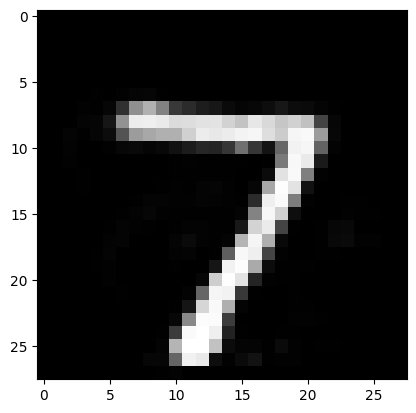

In [ ]:
# test going from 1D to 2D
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)

one_test_img = np.zeros((1,latent_dim))
one_test_img[0,:] = encoded_imgs[0,:]
print(one_test_img.shape)

test_G = G.eval(one_test_img)
print(test_G.shape)
restored = test_G.reshape((1,nx,nx))
print(restored.shape)

plt.figure()
plt.imshow(restored[0])


In [279]:
xtrue = x_test_small[0].numpy()
xtrue_1D = xtrue.reshape((1, -1))
print(xtrue.shape)

(10, 10)


In [284]:
z = np.ones(k)
w = 1
lmbda = 0
sigma = 0

xtrue = x_test_small[0].numpy()
xtrue_1D = xtrue.flatten()

y = A.eval(xtrue_1D) + sigma*np.random.randn(m)

#k  = len(z)//2
#zc = z[:k] + 1j*z[k:]

#print("zc", zc.shape)

print("y", y.shape)

xc = G.eval(z)
Dx = G.jac(z)

print("xc", xc.shape)
print("Dx", Dx.shape)
    
yp = A.eval(xc)
Dy = A.jac(xc)

print("yp", yp.shape)
print("Dy", Dy.shape)

val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2    
gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*z

print("gradc", gradc.shape)
    
grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

print("grad", grad.shape)

y (1000,)
xc (100,)
Dx (100, 10)
yp (1000,)
Dy (1000, 100)
gradc (10,)
grad (20,)


(100,)
xtrue (100,)
yobs (1000,)
k 110
m 1000


c:\Users\Abel\miniconda3\envs\wtf\lib\site-packages\tensorflow\python\framework\constant_op.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


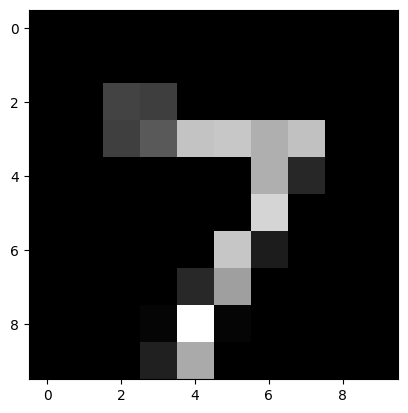

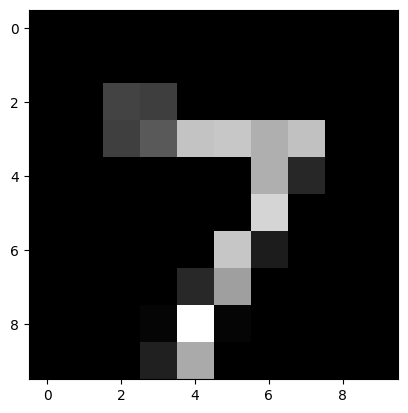

In [29]:
# test with l2
xtrue = x_test_small[0].numpy()
plt.figure()
plt.imshow(xtrue)

xtrue_1D = xtrue.flatten()
print(xtrue_1D.shape)

error, xhat_corr, yobs = reconstruct(xtrue_1D, A, H, w=1, sigma=0, lmbda=0)

xhat_corr = xhat_corr.reshape((nx,nx))

plt.figure()
plt.imshow(np.real(xhat_corr))